In [1]:
import torch
import torch.nn as nn
from nmodel import model, modelArguments
import time
import re
import math

In [2]:
CUDA_LAUCH_BLOCKING = 1

TORCH_USE_CUDA_DSA = True



In [3]:
torch.set_float32_matmul_precision('medium')

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [5]:
fmodel = model(modelArguments)
fmodel = fmodel.to('cuda')



In [7]:
# fmodel(a, a)

In [8]:
for name, para in fmodel.named_parameters():
    print(name)

shared_emb.shared_weight
encoderlayer.self_attn.in_proj_weight
encoderlayer.self_attn.in_proj_bias
encoderlayer.self_attn.out_proj.weight
encoderlayer.self_attn.out_proj.bias
encoderlayer.linear1.weight
encoderlayer.linear1.bias
encoderlayer.linear2.weight
encoderlayer.linear2.bias
encoderlayer.norm1.weight
encoderlayer.norm1.bias
encoderlayer.norm2.weight
encoderlayer.norm2.bias
encoder.layers.0.self_attn.in_proj_weight
encoder.layers.0.self_attn.in_proj_bias
encoder.layers.0.self_attn.out_proj.weight
encoder.layers.0.self_attn.out_proj.bias
encoder.layers.0.linear1.weight
encoder.layers.0.linear1.bias
encoder.layers.0.linear2.weight
encoder.layers.0.linear2.bias
encoder.layers.0.norm1.weight
encoder.layers.0.norm1.bias
encoder.layers.0.norm2.weight
encoder.layers.0.norm2.bias
encoder.layers.1.self_attn.in_proj_weight
encoder.layers.1.self_attn.in_proj_bias
encoder.layers.1.self_attn.out_proj.weight
encoder.layers.1.self_attn.out_proj.bias
encoder.layers.1.linear1.weight
encoder.layer

In [9]:
# mmodel = MathM(modelArguments).to('cuda')
def initialize_weights(m):
    if isinstance(m, torch.nn.Linear):
        nn.init.normal_(m.weight, std=0.1)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.Embedding):
        nn.init.normal_(m.weight, std=0.1)

# Apply the function to the model
fmodel.apply(initialize_weights)


state_dict = torch.load('./checkpoints/model_weightsBPE6.pth')
new_state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}
fmodel.load_state_dict(new_state_dict, strict=False)

<All keys matched successfully>

In [10]:
fmodel = fmodel.to('cuda')
fmodel = torch.compile(fmodel)

In [11]:
count_parameters(fmodel)

33289728

In [12]:
from datasets import load_dataset
from torch.utils.data import DataLoader, IterableDataset
from transformers import PreTrainedTokenizerFast
import pickle
import os
import json

dataset = load_dataset("damerajee/english-to-hindi-l", split="train", streaming=False)


In [13]:
tokenizer = PreTrainedTokenizerFast(tokenizer_file="hinditokenizer.json")


/home/frosthead/.conda/envs/DL/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
def tokenize(text, second = False):
    ids = tokenizer.encode(text, add_special_tokens=True)
    ids1 = [1] + ids + [2] 
    ids1 = torch.tensor(ids1, dtype=torch.int16)
    
    # Pad or truncate the sequence to tholtae max_seq_length
    if ids1.size(0) < modelArguments.max_seq_len:
        padding_length = modelArguments.max_seq_len - ids1.size(0)
        ids1 = torch.cat([ids1, torch.zeros(padding_length, dtype=torch.int16)])
        
    elif ids1.size(0) >= modelArguments.max_seq_len:
        ids1 = ids1[:modelArguments.max_seq_len]
        ids1[-1] = 2
    return ids1

In [15]:
class TokenizedIterableDataset(IterableDataset):
    def __init__(self, dataset, args,state_file='dataset_state.pkl'):
        self.dataset = dataset
        self.state_file = state_file
        self.buffer = ""
        self.current_index = 000
        self.args = args
        # self.load_state()

    def __iter__(self):
        index = 0
        buffer = None
        for example in dataset:
            
            english = tokenize(example['english_sentence'])
            hindi = tokenize(example['hindi_sentence'])


            yield english, hindi



            self.current_index = index
            index += 1


def collate_fn(batch):
    inputs = torch.stack([item[0] for item in batch])
    response = torch.stack([item[1] for item in batch])


    return inputs, response

# Create an instance of the IterableDataset
train_dataset = TokenizedIterableDataset(dataset, modelArguments)

# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=modelArguments.max_batch_size, collate_fn=collate_fn)



In [16]:
var = 0
for k, (a,b)in enumerate(train_dataloader):
    print(a[0])
    print(b[0])
    break
    

# print(var)



tensor([    1,  1629,   439,   375,   798,   341,   729,    29,   476, 21511,
          664,    10, 24740, 13126,  4386,   729,   332,   588,  3509,    17,
        16746,   362, 15520,    12,   829,   369,  3786,   390,   729,    17,
         5228,  2210,   278, 20656,  2509,     4,     2,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [17]:
def id_to_token(x):
    s = ''
    for i in x[0]:
        # j = torch.argmax(i)
        s += tokenizer.decode(i)

    return s

def id_to_token_M(x):
    s = ''
    for i in x[0]:
        j = torch.argmax(i)
        s += tokenizer.decode(j)

    return s

In [18]:
inp = tokenize("Hello, My name is Ayush.").unsqueeze_(0).to(torch.long).to('cuda')
out = tokenize("मेरा नाम ").unsqueeze_(0).to(torch.long).to('cuda')


In [19]:
ans = fmodel(inp, out)

In [20]:
print(id_to_token(out))
print(id_to_token_M(ans))

[SOS]मेरा नाम [EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][

In [23]:
class TransformerLRScheduler(torch.optim.lr_scheduler.LambdaLR):
    def __init__(self, optimizer, d_model, warmup_steps):
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        super().__init__(optimizer, self.lr_lambda)

    def lr_lambda(self, step):
        step = max(step, 1)  # To avoid division by zero
        return (self.d_model ** -0.5) * min(step ** -0.5, step * self.warmup_steps ** -1.5)


In [24]:
history = []
rloss = 0

In [25]:
from torch.utils.tensorboard import SummaryWriter

In [26]:
def log_weights(writer, model, epoch):
    for name, param in model.named_parameters():
        writer.add_histogram(f'{name}.weights', param, epoch)
        if param.grad is not None:
            writer.add_histogram(f'{name}.gradients', param.grad, epoch)

def log_activations(writer, layer_name, output, epoch):
    writer.add_histogram(f'{layer_name}.activations', output, epoch)

In [27]:
writer = SummaryWriter('runs/full_automatic_tracking')

In [28]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
loss_fn2 = nn.MSELoss()
loss_fn3 = nn.MSELoss()
loss_fn4 = nn.MSELoss()
optimizer = torch.optim.AdamW(fmodel.parameters(), betas=(0.9, 0.99), lr = 0.1, weight_decay=0.01, eps=1e-8)
# optimizer.load_state_dict(torch.load('checkpoints/optimizer1.pth'))
optimizer.zero_grad()
torch.cuda.empty_cache()
schedular = TransformerLRScheduler(optimizer, 512, 500)

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_loss_with_trend(loss_array, window_size=25):
    """
    Plots the loss function with an additional line to show the trend.

    Args:
    loss_array (list or np.array): Array of loss values.
    window_size (int): The window size for calculating the moving average trend line.
    """
    # Convert loss_array to a numpy array if it's not already
    loss_array = np.array(loss_array)

    # Calculate the moving average for the trend line
    trend_line = np.convolve(loss_array, np.ones(window_size)/window_size, mode='valid')
    trend = (trend_line[0]-trend_line[-1])/trend_line.size
    trend2 = (trend_line[-1]-trend_line[-window_size-1])/window_size if len(trend_line) > window_size else 0
    

    # Plot the loss function
    print("overall :",trend)
    print("last window :",trend2)

    plt.figure(figsize=(10, 6))
    plt.plot(loss_array, label='Loss', color='blue', alpha=0.6)
    plt.plot(range(window_size - 1, len(loss_array)), trend_line, label='Trend', color='red', linestyle='--', linewidth=2)

    # Adding labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Loss Function with Trend Line')
    plt.legend()
    plt.grid(True)
    plt.savefig('current_loss.jpg')
    plt.show()

In [30]:
optimizer.zero_grad()
torch.cuda.empty_cache()
from IPython.display import clear_output
rloss = 0


In [31]:
open = False
for epoch in range(4000):
    global_step = 0
    sloss = 0
    train_dataloader = DataLoader(train_dataset, batch_size=modelArguments.max_batch_size, collate_fn=collate_fn)
    for batch_idx, (a, b) in enumerate(train_dataloader):
        # if torch.isnan(a).any() or torch.isnan(b).any():
        #     continue
        a = a.to(torch.long).to('cuda')
        b = b.to(torch.long).to('cuda')



        max_no_tokens = 2**8
        accumulation_steps = max_no_tokens//(modelArguments.max_batch_size)

        t0 = time.time()
        out = fmodel(a, b)
        loss = loss_fn(out[:, :modelArguments.max_seq_len-1, :].contiguous().view(-1, out.size(-1)), b[:, 1:modelArguments.max_seq_len].contiguous().view(-1))
        loss = loss / accumulation_steps





        rloss += loss.item()
        # scaler.scale(loss).backward()
        loss.backward()



        if(batch_idx+1) % (2**10) and len(history) > 50 == 0:
            print("Images Saved")
            plot_loss_with_trend(history[1:], window_size=25)

            
        # if loss_fn4(se2,e) >= 10000:
        #     print("out: ", id_to_token(a),"\n")
        #     print("Output shape:", e[0], "\n")
        #     print("Target shape:", se2[0], "\n")
        #     print(loss.item(), loss_fn4(se2,e),loss_fn(out[:, :modelArguments.max_seq_len-1, :].contiguous().view(-1, out.size(-1)), c[:, 1:modelArguments.max_seq_len].contiguous().view(-1)) , loss_fn3(se, d), "\n")
        
        if (batch_idx) % ((max_no_tokens / modelArguments.max_batch_size)*12) == 0 or math.isnan(loss):
            # clear_output(wait=False)
            torch.save(fmodel.state_dict(), 'checkpoints/model_weightsBPE7.pth')
            torch.save(optimizer.state_dict(), 'checkpoints/optimizer2.pth')
            torch.save(history, 'checkpoints/history2.pth')
            # save_and_transfer_checkpoints(model.state_dict(), 'modelWeights.pth', '/home/frosthead/Projects/LLaMA2/', '.')
            ce = loss_fn(out[:, :modelArguments.max_seq_len-1, :].contiguous().view(-1, out.size(-1)), b[:, 1:modelArguments.max_seq_len].contiguous().view(-1))

            
            try:
                writer.add_scalar('Loss/train', rloss, global_step)
                writer.add_scalar('Loss/ce', ce, global_step)
                # writer.add_scalar('Loss/sloss', sloss, global_step)



                # Log weights and gradients
                log_weights(writer, fmodel, global_step)
            except:
                optimizer.zero_grad()
                torch.cuda.empty_cache()
            clear_output()
            print("-"*6,f" Loss: {rloss}", "-"*6,"\n")
            print("inp: ", id_to_token(a),"\n")
            print("true: ", id_to_token(b))
            print("out: ", id_to_token_M(out),"\n")

            print('\n')

            
        
        if (batch_idx+1) % accumulation_steps == 0:
            # scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(fmodel.parameters(), max_norm=1)
            # scaler.step(optimizer)
            optimizer.step()
            schedular.step()
            # scaler.update()
            global_step += 1
            optimizer.zero_grad()

            history.append(rloss)
            
            torch.cuda.synchronize()
            t1 = time.time()

            dt = (t1-t0)*1000 
        # if (batch_idx % 10 == 0):       
            print(f"-----Steps : {global_step}, Loss: {rloss:8f}, LR: {schedular.get_last_lr()}, #tokens : {max_no_tokens} ,timeT : {dt}ms ----- ")
            # print(f"-----Steps : {global_step}, BatchIDX : {batch_idx}, Loss: {rloss:8f}, #tokens : {max_no_tokens} ,timeT : {dt}ms ----- ")

            rloss = 0
        torch.cuda.empty_cache()

    print(f"Epoch {epoch+1} completed, {batch_idx}")   


# Close the writer after training
writer.close()

# Remove hooks after training is done
# for hook in hooks:
#     hook.remove()


------  Loss: 0.047337550669908524 ------ 

inp:  [SOS]Burn an existing CD / DVD image to disc[EOS][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][

KeyboardInterrupt: 

In [41]:
se[0], e[0]

(tensor([[4.6746e+00, 3.5948e+00, 3.0292e+00, 2.2992e+00, 1.9814e+00, 1.6484e+00,
          1.1950e+00, 1.4389e+00, 1.0268e+00, 9.2477e-01, 8.2266e-01, 7.3887e-01,
          3.5669e-01, 6.2320e-01, 5.9211e-01, 3.3420e-01, 8.9923e-02, 9.2636e-02,
          4.3759e-01, 6.2237e-02, 6.7157e-01, 3.7226e-01, 1.7359e-01, 5.0016e-01,
          1.0000e+01, 1.3141e-01, 3.0200e-01, 2.4225e-01, 6.4371e-02, 3.6889e-01,
          1.9881e-01, 6.5745e-01, 1.1970e-01, 1.0317e-01, 3.0235e-01, 4.6172e-01,
          3.3271e-01, 4.9603e-01, 1.1059e-01, 1.1381e-01, 1.8963e-01, 1.3152e-01,
          2.2227e-01, 1.2889e-01, 1.2541e-01, 4.6300e-01, 2.9229e-01, 1.3701e-01,
          6.2920e-02, 1.1754e-01, 0.0000e+00, 2.2004e-01, 1.8300e-05, 1.1929e-01,
          3.9607e-01, 1.5108e-01, 3.2215e-01, 3.9339e-01, 2.4935e-01, 2.3376e-02,
          1.9834e-01, 9.5308e-02, 3.1176e-01, 1.7991e-01]], device='cuda:0',
        grad_fn=<SelectBackward0>),
 tensor([[10.0000,  3.4000, 10.0000,  3.4000,  0.4000,  0.4000,  3.

In [32]:
torch.save(fmodel.state_dict(), 'checkpoints/model_weightsBPE6.pth')
torch.save(optimizer.state_dict(), 'checkpoints/optimizer1.pth')
torch.save(history, 'checkpoints/history1.pth')             

overall : 0.006014817004779515
last window : 0.0006337717920542385


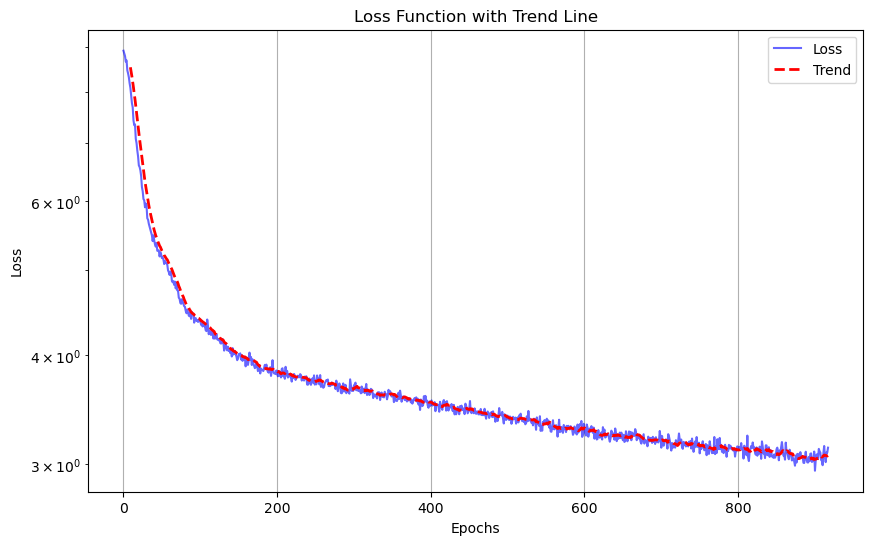

In [34]:
# plt.plot(history[3920:])
# plt.yscale('log')
# plt.show()
history = torch.load('checkpoints/history1.pth')
plot_loss_with_trend(history[8:], window_size=10)